# Example of Jaraguari RADAR file reading #

- Rain rate (mm/h) at CAPPI 3 km (Process reference: https://journals.ametsoc.org/view/journals/apme/44/4/jam2213.1.xml)

In [17]:
import numpy as np 
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import geopy
from geopy import distance

In [ ]:
#file properties
ds=xr.open_dataset('jaraguari_201801010130.nc')
ds

<xarray.Dataset> Size: 15MB
Dimensions:        (x: 500, y: 500)
Coordinates:
  * x              (x) float64 4kB -56.84 -56.83 -56.82 ... -52.07 -52.06 -52.05
  * y              (y) float64 4kB -22.51 -22.5 -22.49 ... -18.04 -18.03 -18.02
Data variables: (12/15)
    cappi_3km_CZ   (y, x) float32 1MB ...
    ppi_0.5deg_CZ  (y, x) float32 1MB ...
    ppi_1.5deg_CZ  (y, x) float32 1MB ...
    ppi_2.5deg_CZ  (y, x) float32 1MB ...
    ppi_0.5deg_DR  (y, x) float32 1MB ...
    ppi_1.5deg_DR  (y, x) float32 1MB ...
    ...             ...
    ppi_2.5deg_KD  (y, x) float32 1MB ...
    cappi_3km_DR   (y, x) float32 1MB ...
    cappi_3km_KD   (y, x) float32 1MB ...
    r_kdp          (y, x) float32 1MB ...
    r_zr           (y, x) float32 1MB ...
    rain           (y, x) float32 1MB ...
Attributes:
    Conventions:  CF-1.7
    GMT_version:  6.0.0 [64-bit]
    NCO:          netCDF Operators version 4.9.1 (Homepage = http://nco.sf.ne...
    title:        Radar jaraguari
    scan:         20180101_0130

In [32]:
#load variables
Longitude = ds['x']
Latitude = ds['y']
RR = ds['rain']

In [29]:
#plotting functions

def scam_circle(lon_r, lat_r,dis):
    origin = geopy.Point(lat_r, lon_r)

    lons = np.zeros((361))
    lats = np.zeros((361))
    for az in range(361):
        destination = distance.distance(kilometers=dis).destination(origin, az)
        lat2, lon2 = destination.latitude, destination.longitude
        lons[az] = lon2
        lats[az] = lat2

    return lons,lats

radar_central_lon=-54.44;radar_central_lat=-20.26
radar_scam=scam_circle(radar_central_lon,radar_central_lat,250)

def cartopy_settings(ax):
    ax.set_extent([-58.5, -50.5, -24.5, -17], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS,linewidth=3)
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.STATES)
    #insert lat and lon lines
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=.2, color='gray', alpha=0.5, linestyle='--')
    gl.left_labels = True
    gl.bottom_labels = True
    gl.right_labels = False
    gl.top_labels = False


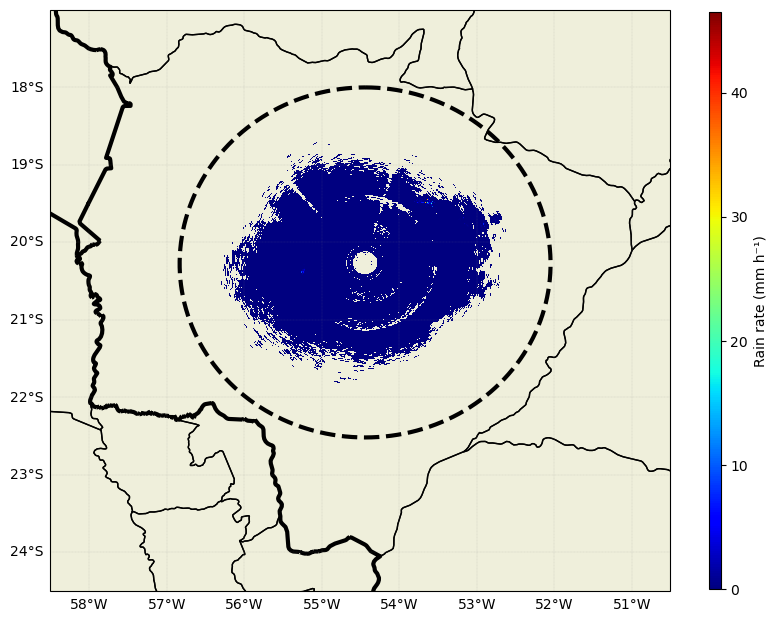

In [33]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
cartopy_settings(ax)
ax.plot(radar_scam[0],radar_scam[1],'--',c='k',linewidth=3,transform=ccrs.PlateCarree())

cf=ax.pcolormesh(Longitude,Latitude,RR,transform=ccrs.PlateCarree(),cmap='jet')
#colorbar for cf
plt.colorbar(cf, aspect=50,shrink=.75,label='Rain rate (mm h⁻¹)')